In this notebook, we apply GMM-MI to calculate the MI between categorical and continuous variables. We will use the the [3D Shapes dataset](https://github.com/deepmind/3d-shapes), on which we have pre-trained a $\beta$-variational autoencoder with 6 latents. We provide the categorical variables and the latents in a specific format:

- `latents` has shape `(n_samples, n_latents)`, and is obtained by feeding the data, and sampling one point from each latent distribution.

- `categories` has shape `(n_samples, n_categories)`, and is obtained by indicating for each data point what is the discrete value assumed by each category.

The total number of MI values calculated is `n_latents x n_categories`, and will be `6 x 6 = 36` in this notebook. We used `n_samples = 48000`, i.e. the test set with 10% of the data available. We also use as input a dictionary `dict_labels`, indicating each category and the number of values it can assume.

### Import packages

In [1]:
import numpy as np
import yaml
from gmm_mi.gmm import GMM
from gmm_mi.mi import EstimateMI
from gmm_mi.utils.plotting import create_heatmap, annotate_heatmap

### Load the categorical variables and latents

In [2]:
category_list = ['floor_hue', 'object_hue', 'orientation', 'scale', 'shape', 'wall_hue']
categories = np.load('./3D_shapes_data/categories.npy')
# from pre-trained beta-VAE model
latents = np.load('./3D_shapes_data/latents.npy')
n_latents = latents.shape[1]

### Calculate MI for all latents and categories

In [3]:
run_this_cell = False

if not run_this_cell:
    print('Not running this cell...')
    pass
else:
    print(f'Estimating MI...')
    all_MI_estimates = np.zeros((len(category_list), n_latents, 2))
    save = False
    
    # load parameters from yaml file and assign them to variables
    # not the cleanest and safest way, but it should work
    with open('./config_files/config_parameters_9-11.yml', 'rb') as f:
        conf = yaml.safe_load(f.read())
    locals().update(conf)
    
    for category_id, category in enumerate(category_list):
        for latent_id in range(n_latents):
            # get current continuous feature (a latent)
            current_cont_feat = latents[:, latent_id]
            # get current category           
            current_cat_feat = categories[:, category_id]
            
            MIEstimator = EstimateMI(n_folds=n_folds, n_inits=n_inits, init_type=init_type, reg_covar=reg_covar, 
                                     tol=tol, max_iter=max_iter, bootstrap=bootstrap, n_bootstrap=n_bootstrap, 
                                     MC_samples=MC_samples, metric_method=metric_method, patience=patience, 
                                     verbose=verbose)
            MI_mean, MI_std = MIEstimator.fit_categorical(X=current_cont_feat,
                                                          y=current_cat_feat)   

            all_MI_estimates[category_id, latent_id, 0] = MI_mean
            all_MI_estimates[category_id, latent_id, 1] = MI_std

            if save:
                np.save(f'./results/MI_3D_shapes.npy', all_MI_estimates)

Not running this cell...


### Plot results

In [4]:
# load pre-saved results
all_MI_estimates = np.load(f'./results/MI_3D_shapes.npy')

In [5]:
y_labels = [label.capitalize().replace("_", " ") for label in category_list]
x_labels = [f"$z_{i}$" for i in range(1, 7)]#[f"$z_{i+$" for i in range(6)]
# we only look at the mean MI values for this plot, so we ignore the MI uncertainty
MI_values = all_MI_estimates[:, :, 0]

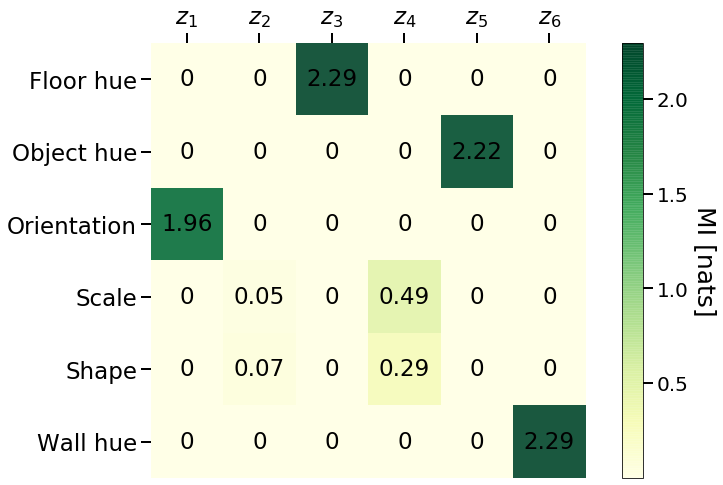

In [6]:
im, cbar = create_heatmap(MI_values, y_labels, x_labels, cmap="YlGn", 
                          cbarlabel="MI [nats]", alpha=0.9, fsize=23)
texts = annotate_heatmap(im, valfmt="{x:.2f}", save_fig=True, 
                         save_path='./figures/MI_shapes3D_hm.pdf',
                         fontsize=23)